In [1]:
import pandas as pd 
import numpy as np
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset , DataLoader

In [2]:
df = pd.read_csv("OMC_CSV_final.csv" , sep=';')
df["Date"] = pd.to_datetime(df["Date"],dayfirst=True)
df["Call Drop Rate"] = pd.to_numeric(df["Call Drop Rate"] , errors="coerce")
df["SDCCH drop rate  "] = pd.to_numeric(df["SDCCH drop rate  "] , errors="coerce")
print(df.info())
df.head()
print(f"Max CDR : ",max(df["Call Drop Rate"]))
print(f"Min CDR : ",min(df["Call Drop Rate"]))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84663 entries, 0 to 84662
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         84663 non-null  datetime64[ns]
 1   BSC                          83631 non-null  object        
 2   Site                         84663 non-null  object        
 3   Cell                         84663 non-null  object        
 4    RTCH Attemps                84663 non-null  object        
 5   RTCH Assignment Fail Rate    83913 non-null  float64       
 6    RTCH successfully seized    84663 non-null  object        
 7   RTCH HO successfull          84663 non-null  int64         
 8   RTCH Assignment Normal Rate  83950 non-null  float64       
 9   Call Drop Rate               83943 non-null  float64       
 10  RTCH_traffic_offered_avg     84663 non-null  float64       
 11  RTCH Erlang Busy Hour        84659 non-nu

In [3]:
from sklearn.preprocessing import RobustScaler
import numpy as np
site_names =  df["Site"].unique().tolist()
cell_names = df["Cell"].unique().tolist()
site_to_id = {name: idx for idx, name in enumerate(site_names)}
cell_to_id = {name: idx for idx, name in enumerate(cell_names)}
seq_len = 15
features_cols = ["Call Drop Rate", "SDCCH drop rate  ", "RTCH Assignment Fail Rate"]

# 1. Fit scalers globally (on the full dataset)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit on all feature data (excluding Date, Site, Cell)
scaler_x.fit(df[features_cols].values)
scaler_y.fit(df[["Call Drop Rate"]].values)

all_seq = []

for site in site_names:
    site_df = df[df["Site"] == site].sort_values("Date")
    site_df = site_df[["Date","Cell"] + features_cols].dropna()
    cells_in_site = site_df["Cell"].unique()
    
    for cell in cells_in_site:
        cell_df = site_df[site_df["Cell"] == cell]

        if len(cell_df) < seq_len + 1:
            continue
        
        # Apply the global scaler
        features = scaler_x.transform(cell_df[features_cols].astype(float).values)
        cdr = scaler_y.transform(cell_df[["Call Drop Rate"]].astype(float).values).flatten()
        
        for i in range(len(features) - seq_len):
            x = features[i:i+seq_len]
            y = cdr[i + seq_len]
            
            site_id = site_to_id[site]
            cell_id = cell_to_id[cell]
            
            all_seq.append((x, site_id, cell_id, y))

print(f"Total sequences: {len(all_seq)}")


Total sequences: 54018


In [4]:
print(all_seq[3])
print(" ")
print(all_seq[4])

(array([[0.0058    , 0.01212415, 0.04906631],
       [0.0054    , 0.01042677, 0.04868521],
       [0.0064    , 0.0143065 , 0.04916159],
       [0.0052    , 0.0113967 , 0.04849466],
       [0.0045    , 0.01357905, 0.04897104],
       [0.0161    , 0.01527643, 0.05830793],
       [0.0101    , 0.01260912, 0.05278201],
       [0.0073    , 0.01357905, 0.04868521],
       [0.0063    , 0.0128516 , 0.04858994],
       [0.0085    , 0.01721629, 0.04916159],
       [0.0084    , 0.01624636, 0.04868521],
       [0.0072    , 0.01745878, 0.04792302],
       [0.0075    , 0.0157614 , 0.04868521],
       [0.0088    , 0.01357905, 0.04820884],
       [0.0085    , 0.01260912, 0.04858994]]), 0, 19, np.float64(0.0086))
 
(array([[0.0054    , 0.01042677, 0.04868521],
       [0.0064    , 0.0143065 , 0.04916159],
       [0.0052    , 0.0113967 , 0.04849466],
       [0.0045    , 0.01357905, 0.04897104],
       [0.0161    , 0.01527643, 0.05830793],
       [0.0101    , 0.01260912, 0.05278201],
       [0.0073    , 0.

In [5]:
class MultiSiteDataset(Dataset):
    def __init__(self,sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        x,site_id,cell_id,y=self.sequences[idx]
        return(
            torch.tensor(x,dtype=torch.float32),
            torch.tensor(site_id,dtype=torch.long),
            torch.tensor(cell_id,dtype=torch.long),
            torch.tensor(y,dtype=torch.float32)
        )

In [6]:
dataset = MultiSiteDataset(all_seq)

train_size = int(0.7*len(dataset))
val_size   = int(0.15*len(dataset))
test_size  = len(dataset) - train_size - val_size
train_dataset,val_dataset,test_dataset = torch.utils.data.random_split(dataset,[train_size,val_size,test_size])
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader   = DataLoader(val_dataset,batch_size=32,shuffle=False)
test_loader  = DataLoader(test_dataset,batch_size=1,shuffle=False)
print(f"Features (Input to the LSTM) \n" , dataset[3][0])
print(f"Site ------------>",dataset[3][1])
print(f"CELL ------------>",dataset[3][2])
print(f"Next CDR Value -->",dataset[3][3])

Features (Input to the LSTM) 
 tensor([[0.0058, 0.0121, 0.0491],
        [0.0054, 0.0104, 0.0487],
        [0.0064, 0.0143, 0.0492],
        [0.0052, 0.0114, 0.0485],
        [0.0045, 0.0136, 0.0490],
        [0.0161, 0.0153, 0.0583],
        [0.0101, 0.0126, 0.0528],
        [0.0073, 0.0136, 0.0487],
        [0.0063, 0.0129, 0.0486],
        [0.0085, 0.0172, 0.0492],
        [0.0084, 0.0162, 0.0487],
        [0.0072, 0.0175, 0.0479],
        [0.0075, 0.0158, 0.0487],
        [0.0088, 0.0136, 0.0482],
        [0.0085, 0.0126, 0.0486]])
Site ------------> tensor(0)
CELL ------------> tensor(19)
Next CDR Value --> tensor(0.0086)


In [7]:
import  torch.nn.functional as F 

class LSTMModel(nn.Module):
    def __init__(self,num_sites,num_cells,seq_len,emb_dim=16,input_size=3,hidden_size=128,num_layers=3,dropout_rate=0.1):
        super(LSTMModel,self).__init__()
        self.seq_len = seq_len
        self.lstm = nn.LSTM(
            input_size=input_size,hidden_size=hidden_size,
            num_layers=num_layers,batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0
            )
        self.site_embedding = nn.Embedding(num_sites,emb_dim)
        self.cell_embedding = nn.Embedding(num_cells,emb_dim)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        #self.flatten_dim = hidden_size * self.seq_len 
        self.Gelu = nn.GELU()
        self.fc1 = nn.Linear(hidden_size ,128)
        self.fc_final = nn.Sequential(
            nn.Linear(128 + emb_dim *2 ,1),
            nn.Sigmoid()
        )
    def forward(self,x,site,cell):
        out,_ = self.lstm(x)
        out = self.layer_norm(out)
        out = self.dropout(out)
        out = out[:,-1,:]
        #out = out.reshape(out.shape[0],-1)
        out = self.Gelu(out)
        out=self.fc1(out)
        site_emb = self.site_embedding(site)
        cell_emb = self.cell_embedding(cell)
        combined = torch.cat((out,site_emb,cell_emb),dim=1)
        output = self.fc_final(combined) ## the output from last time step 
        return output

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score

In [12]:
model = LSTMModel(num_sites=515,num_cells=2004,seq_len=seq_len).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.0006,weight_decay=1e-5) 
train_losses = []
val_losses   = []
num_epochs = 25
## training 
for epoch in range(num_epochs):
    model.train()
    run_train_loss = 0.0
    for x_batch,site,cell,y_batch in train_loader : 
        site = site.to(device)
        cell = cell.to(device)
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).view(-1,1)
        optimizer.zero_grad()
        output = model(x_batch,site,cell)
        loss = criterion(output,y_batch)
        loss.backward()
        optimizer.step()
        run_train_loss += loss.item() 
    avg_train_loss = run_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    run_val_loss = 0.0
    with torch.no_grad():
        for x_batch,site,cell,y_batch in val_loader :
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).view(-1,1)
            site = site.to(device)
            cell = cell.to(device)
            output = model(x_batch,site,cell)
            val_loss = criterion(output,y_batch)
            run_val_loss += val_loss.item()
    avg_val_loss = run_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {avg_train_loss:.4f} -- Val Loss: {avg_val_loss:.4f}")

plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
        

Epoch 1/25 -- Train Loss: 0.0088 -- Val Loss: 0.0047
Epoch 2/25 -- Train Loss: 0.0053 -- Val Loss: 0.0044
Epoch 3/25 -- Train Loss: 0.0050 -- Val Loss: 0.0043
Epoch 4/25 -- Train Loss: 0.0049 -- Val Loss: 0.0049
Epoch 5/25 -- Train Loss: 0.0048 -- Val Loss: 0.0042
Epoch 6/25 -- Train Loss: 0.0046 -- Val Loss: 0.0044
Epoch 7/25 -- Train Loss: 0.0046 -- Val Loss: 0.0041
Epoch 8/25 -- Train Loss: 0.0045 -- Val Loss: 0.0042
Epoch 9/25 -- Train Loss: 0.0044 -- Val Loss: 0.0041
Epoch 10/25 -- Train Loss: 0.0044 -- Val Loss: 0.0040
Epoch 11/25 -- Train Loss: 0.0043 -- Val Loss: 0.0041
Epoch 12/25 -- Train Loss: 0.0042 -- Val Loss: 0.0042
Epoch 13/25 -- Train Loss: 0.0042 -- Val Loss: 0.0040
Epoch 14/25 -- Train Loss: 0.0042 -- Val Loss: 0.0040
Epoch 15/25 -- Train Loss: 0.0042 -- Val Loss: 0.0040
Epoch 16/25 -- Train Loss: 0.0041 -- Val Loss: 0.0040
Epoch 17/25 -- Train Loss: 0.0041 -- Val Loss: 0.0040
Epoch 18/25 -- Train Loss: 0.0041 -- Val Loss: 0.0040
Epoch 19/25 -- Train Loss: 0.0041 -- 

KeyboardInterrupt: 

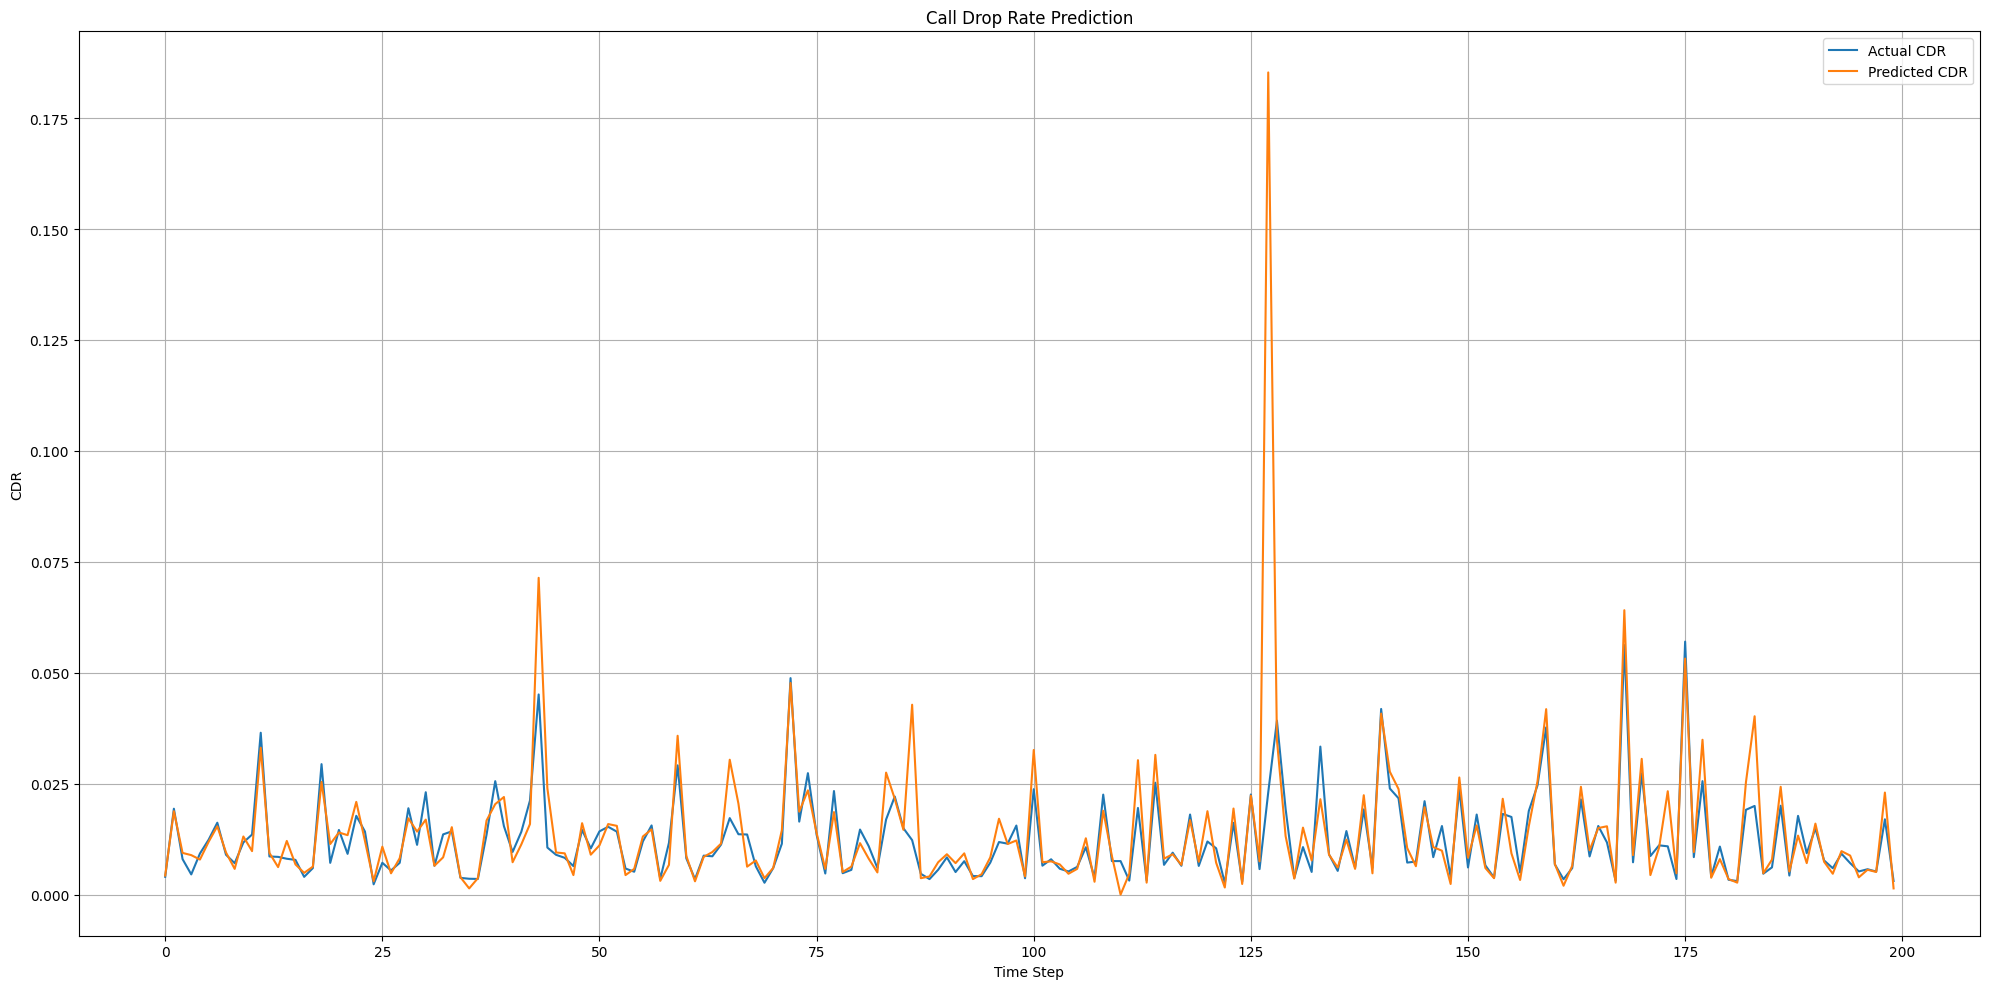

MAE  : 0.0038
MSE  : 0.0001
RMSE : 0.0110
R²   : 0.5185


In [15]:
model.eval()
preds, y = [], []

with torch.no_grad():
    for x_batch, site_batch,cell_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        site_batch = site_batch.to(device)
        cell_batch = cell_batch.to(device)

        output = model(x_batch, site_batch,cell_batch)

        preds.extend(output.cpu().numpy().flatten())
        y.extend(y_batch.cpu().numpy().flatten())

# Inverse scaling
predicted_cdr = scaler_y.inverse_transform(np.array(preds).reshape(-1, 1))
true_cdr = scaler_y.inverse_transform(np.array(y).reshape(-1, 1))
# Plot
plt.figure(figsize=(20, 10))
plt.plot(predicted_cdr[:200], label="Actual CDR")
plt.plot(true_cdr[:200], label="Predicted CDR")
plt.legend()
plt.title("Call Drop Rate Prediction")
plt.xlabel("Time Step")
plt.ylabel("CDR")
plt.grid(True)
plt.tight_layout()
plt.show()

mae  = mean_absolute_error(true_cdr, predicted_cdr)
mse  = mean_squared_error(true_cdr, predicted_cdr)
rmse = np.sqrt(mse)
r2   = r2_score(true_cdr, predicted_cdr)

print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")